<a href="https://colab.research.google.com/github/ibagayoko/vfaker/blob/master/VFaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clonage de la voix 

In [0]:
!rm -rf vfaker

## Recuperons l'ocodeur et l'encodeur

In [0]:
import os
from os.path import exists, join, expanduser

# Clone
vocoder_name = "deepvoice3_pytorch"
if not exists(vocoder_name):
  ! git clone https://github.com/ibagayoko/$vocoder_name dv3
    
encoder_name = "vfaker"
if not exists(vocoder_name):
  ! git clone https://github.com/ibagayoko/$encoder_name vfaker

Cloning into 'dv3'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1126 (delta 0), reused 1 (delta 0), pack-reused 1123
Receiving objects: 100% (1126/1126), 45.72 MiB | 38.79 MiB/s, done.
Resolving deltas: 100% (624/624), done.
Cloning into 'vfaker'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31 (delta 5), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [0]:
! pip install -q librosa nltk lws unidecode nnmnkwii tensorboardX

    100% |████████████████████████████████| 143kB 10.2MB/s 
    100% |████████████████████████████████| 245kB 24.7MB/s 
    100% |████████████████████████████████| 1.7MB 13.5MB/s 
    100% |████████████████████████████████| 133kB 27.1MB/s 
    100% |████████████████████████████████| 368kB 27.9MB/s 
    100% |████████████████████████████████| 430kB 22.6MB/s 


In [0]:
import torch
import numpy as np
import librosa
import librosa.display
import IPython
from IPython.display import Audio
# need this for English text processing frontend
import nltk
! python -m nltk.downloader cmudict

### Download a pre-trained model for the vocoder

In [0]:
checkpoint_path = "20171222_deepvoice3_vctk108_checkpoint_step000300000.pth"

In [0]:
if not exists(checkpoint_path):
  !curl -O -L "https://www.dropbox.com/s/uzmtzgcedyu531k/20171222_deepvoice3_vctk108_checkpoint_step000300000.pth"

In [0]:
# Copy preset file (json) from master
# The preset file describes hyper parameters for tthe vocoder (deepvoice3)
preset = "./dv3/presets/deepvoice3_vctk.json"
! cp -v $preset .
preset = "./deepvoice3_vctk.json"

### Setup hyper parameters

In [0]:
from dv3 import hparams
import json

# Newly added params. Need to inject dummy values
for dummy, v in [("fmin", 0), ("fmax", 0), ("rescaling", False),
                 ("rescaling_max", 0.999), 
                 ("allow_clipping_in_normalization", False)]:
  if hparams.get(dummy) is None:
    hparams.add_hparam(dummy, v)
    
# Load parameters from preset
with open(preset) as f:
  hparams.parse_json(f.read())

# Tell we are using multi-speaker DeepVoice3
hparams.builder = "deepvoice3_multispeaker"
  
# Inject frontend text processor
from dv3 import synthesis
from dv3 import train
from dv3.deepvoice3_pytorch import frontend
synthesis._frontend = getattr(frontend, "en")
train._frontend =  getattr(frontend, "en")

# alises
fs = hparams.sample_rate
hop_length = hparams.hop_size

### Define utility functions

In [0]:
def tts(model, text, p=0, speaker_id=0, fast=True, figures=True):
  from dv3.synthesis import tts as _tts
  waveform, alignment, spectrogram, mel = _tts(model, text, p, speaker_id, fast)
  if figures:
      visualize(alignment, spectrogram)
  IPython.display.display(Audio(waveform, rate=fs))
  return mel

  
def visualize(alignment, spectrogram):
  from matplotlib import pyplot as plt
  label_fontsize = 16
  plt.figure(figsize=(16,16))

  plt.subplot(2,1,1)
  plt.imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
  plt.xlabel("Decoder timestamp", fontsize=label_fontsize)
  plt.ylabel("Encoder timestamp", fontsize=label_fontsize)
  plt.colorbar()

  plt.subplot(2,1,2)
  librosa.display.specshow(spectrogram.T, sr=fs, 
                           hop_length=hop_length, x_axis="time", y_axis="linear")
  plt.xlabel("Time", fontsize=label_fontsize)
  plt.ylabel("Hz", fontsize=label_fontsize)
  plt.tight_layout()
  plt.colorbar()

### Load the model checkpoint

In [0]:
from dv3.train import build_model
from dv3.train import restore_parts, load_checkpoint

vocoder = build_model()
vocoder = load_checkpoint(checkpoint_path, vocoder, None, True)

In [0]:
!mv dv3/Cloning_Audio/ ./Cloning_Audio

In [0]:
cloned_voices = None


In [0]:
import pickle
with open("./Cloning_Audio/speakers_cloned_voices_mel.p" , "rb") as fp:
            cloned_voices = pickle.load(fp)

In [0]:
from dv3.utils import get_cloned_voices, get_embed_speakers
# Values that model should be train on
# cloned_voices = get_cloned_voices(vocoder)

# The ground tru
emdeds = get_embed_speakers(vocoder)

In [0]:
from vfaker.utils import prepareMelSpec
cloned_voices = prepareMelSpec(cloned_voices)

In [0]:
from vfaker.baidu import build_model as build_baidu_encoder
encoder = build_baidu_encoder(N_prenet=1)

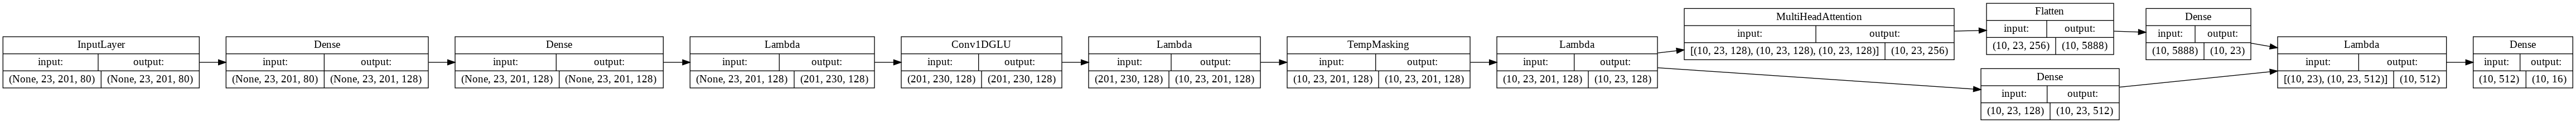

In [0]:
#  source : https://laujohn.com/2018/09/24/Plot-Keras-Model-in-Colaboratory/
from IPython.display import Image
from keras.utils import plot_model

plot_model(encoder, show_layer_names=False, show_shapes=True,  to_file='model.png', rankdir='LR')

Image(retina=True, filename='model.png')

#### Définition de callbacks
- checkpoint afin de ne sauver que le meilleur modèle

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('./baidu_encoder-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', save_weights_only=True,  monitor='val_loss', verbose=1, save_best_only=True )  
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

In [0]:
# compile the model
adam = keras.optimizers.Adam(lr=0.006, amsgrad=True)
encoder.compile(optimizer=adam, loss='mean_absolute_error',  metrics=['acc'])

In [0]:
N_EPOCHS = 500

In [0]:
X_train = cloned_voices[:100]
y_train = emdeds[:100]

In [0]:
X_train.shape

(100, 23, 201, 80)

In [0]:
import keras
# datagen = keras.preprocessing.image.ImageDataGenerator(validation_split=.2)
# # training_data = datagen.flow(X_train, y_train, subset='training', shuffle=True, batch_size=10)
# val_data = datagen.flow(X_train, y_train, subset='validation', shuffle=True, batch_size=10)

In [0]:
# history = encoder.fit_generator(training_data, validation_data=val_data)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=20, shuffle=True)

In [0]:

history = encoder.fit(X_train, 
                      y_train, batch_size=10,  
                      epochs=N_EPOCHS, validation_data=[X_val, y_val],
                      callbacks=[checkpoint], verbose=1)

Train on 80 samples, validate on 20 samples
Epoch 1/500
80/80 [==============================] - 13s 163ms/step - loss: 0.2237 - acc: 0.1500 - val_loss: 0.2183 - val_acc: 0.1000

Epoch 00001: val_loss improved from 0.22181 to 0.21829, saving model to ./baidu_encoder-001-0.150000-0.100000.h5
Epoch 2/500
80/80 [==============================] - 14s 170ms/step - loss: 0.2208 - acc: 0.1250 - val_loss: 0.2097 - val_acc: 0.1000

Epoch 00002: val_loss improved from 0.21829 to 0.20967, saving model to ./baidu_encoder-002-0.125000-0.100000.h5
Epoch 3/500
80/80 [==============================] - 14s 169ms/step - loss: 0.2183 - acc: 0.1750 - val_loss: 0.2073 - val_acc: 0.1500

Epoch 00003: val_loss improved from 0.20967 to 0.20730, saving model to ./baidu_encoder-003-0.175000-0.150000.h5
Epoch 4/500
80/80 [==============================] - 14s 169ms/step - loss: 0.2159 - acc: 0.2250 - val_loss: 0.2093 - val_acc: 0.1000

Epoch 00004: val_loss did not improve from 0.20730
Epoch 5/500
80/80 [=======

In [0]:
from matplotlib import pyplot as plt

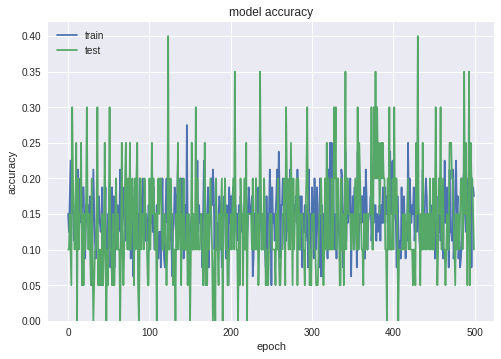

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(bottom=0)
plt.show()

In [0]:
encoder.save_weights("fdf")

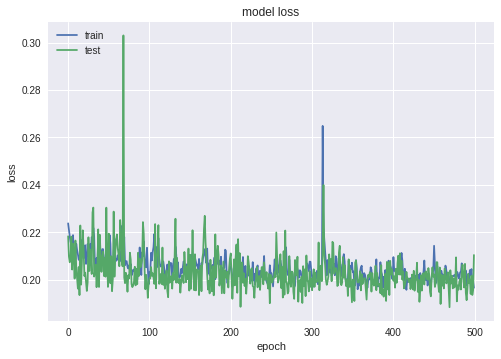

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test
On charge notre meilleur modèle

In [0]:
# encoder.load_weights("baidu_encoder-069-0.525000-0.450000.h5")
encoder.load_weights("baidu_encoder-030-0.562500-0.500000.h5")

In [0]:
encoder.compile("adam", loss="mae", metrics=["acc"])

In [0]:
# Dupliquer le vocodeur
vocoderb = vocoder

#### Accuray de sur nos test

In [36]:
scores = encoder.evaluate(cloned_voices[98:], emdeds[98:])
print("\n%s: %.2f%%" % (encoder.metrics_names[1], scores[1]*100))

10/10 [==============================] - 0s 32ms/step

acc: 20.00%


### Génération de nouveaux audio

In [0]:
# On recupère l'encodage  de nos speaker
result =  encoder.predict(cloned_voices[98:])

In [0]:
# Pour le moment c'est du numpy 
# et DeepVoice ne comprend que lees tensor de pytorch
result[-1]

array([ 0.5406273 ,  0.30886352,  0.2495578 , -0.5355255 , -0.6706789 ,
        0.4317846 ,  0.09272122,  0.09073512, -0.03197032,  0.18518706,
       -0.35435507, -0.10422669,  0.19907245,  0.02100456, -0.21420774,
       -0.22344571], dtype=float32)

In [0]:
# On les convertie en du pytorh et on change des position specifique generer de nouveaux audio
vocoderb.embed_speakers.weight.data[0] = torch.tensor(result[5])

vocoderb.embed_speakers.weight.data[1]  = torch.tensor(emdeds[103])


Synthesizing "I love deep learning, but I don't like wait for training to complete" with 15 different speakers
0


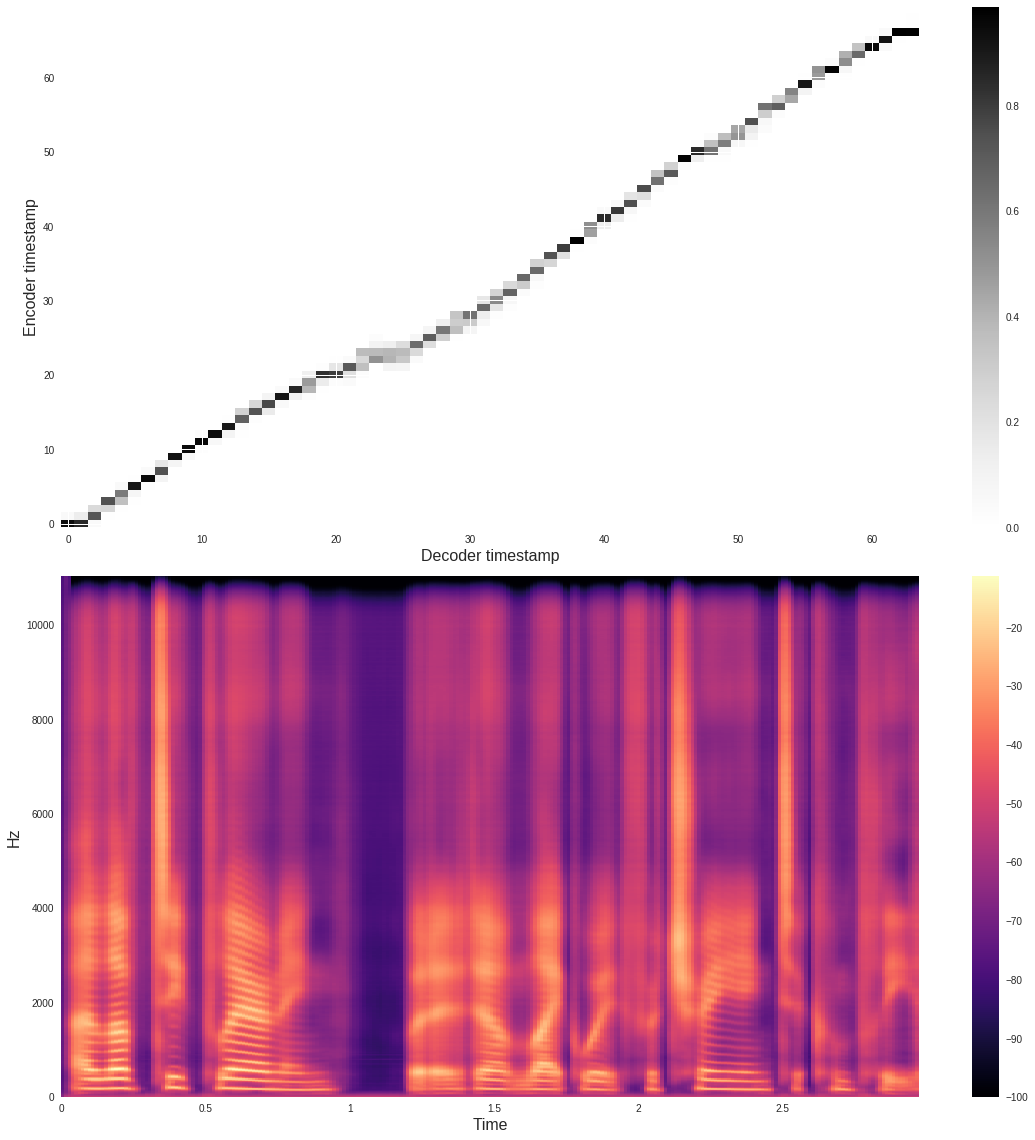

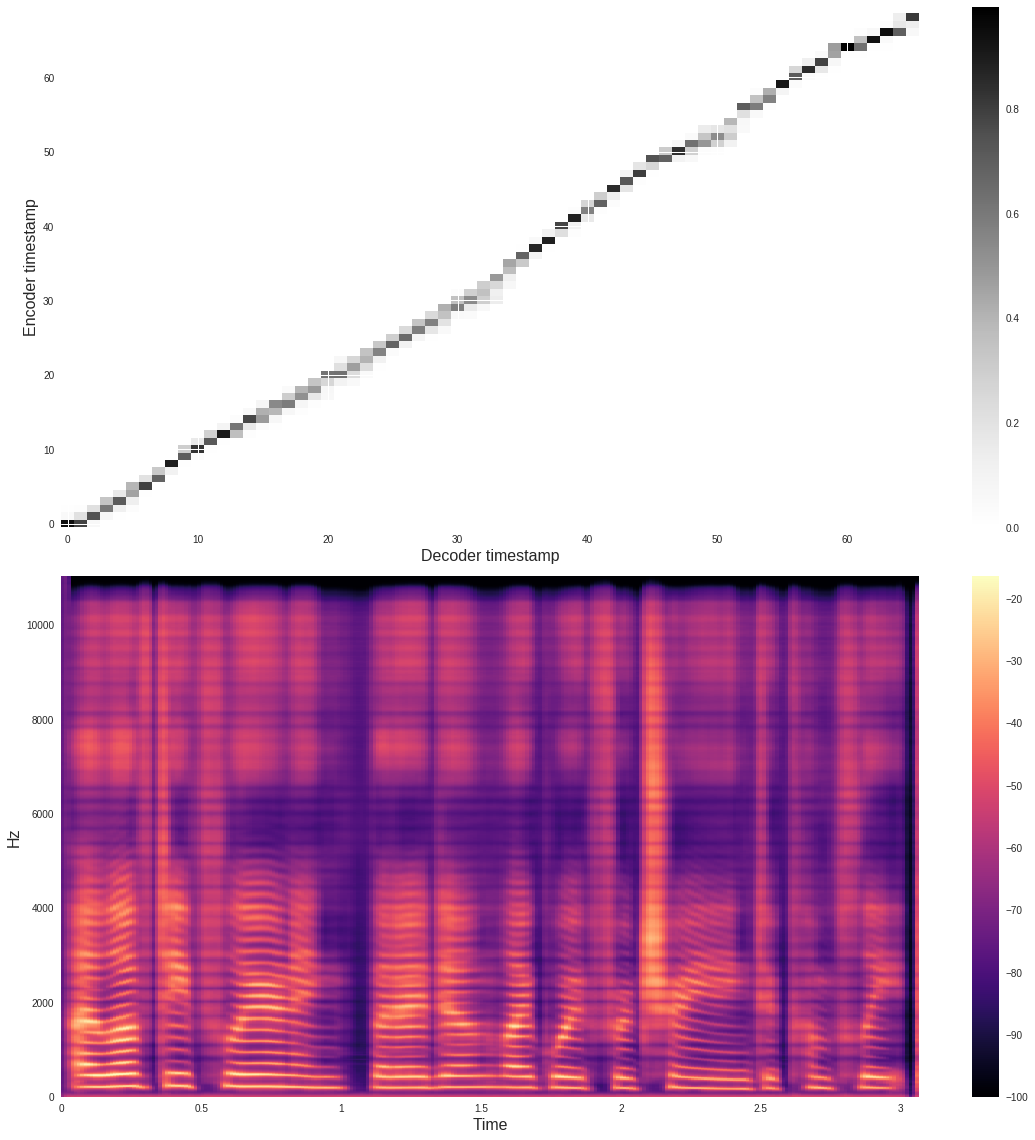

In [0]:
# Try your favorite senteneces:)
text = "I love deep learning, but I don't like wait for training to complete"
N = 15
print("Synthesizing \"{}\" with {} different speakers".format(text, N))
speaker_id = 0
print(speaker_id)
out1 = tts(vocoderb, text, speaker_id=0, figures=True)
out2 = tts(vocoderb, text, speaker_id=1, figures=True)

### Testons sur ma voix

In [0]:
!curl -L -O https://github.com/ibagayoko/vfaker/releases/download/myvoices/myv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   598    0   598    0     0   1491      0 --:--:-- --:--:-- --:--:--  1487
100 3590k  100 3590k    0     0  2928k      0  0:00:01  0:00:01 --:--:-- 20.9M


In [0]:
!unzip -q myv.zip

In [0]:
import librosa
import numpy as np

In [0]:
myv = np.zeros((10,23,201,80))

In [0]:
for i in range(1,24):
  y, sr = librosa.load("myv/{}.wav".format(i))
  mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80,     fmax=8000)
#   Librosa nous donne un format (80, T ) => (T, 80)
  mel = mel.swapaxes(0,1)
  final = np.zeros((201, 80))
#   if mel.shape[0] <= 201:
#     final[:mel.shape[0], :] += mel[:mel.shape[0] ]
#   else:
#     final = myv[0][i-2] #final[:mel.shape[0], :] += mel[:mel.shape[0] ]
  final2[:mel.shape[0] if mel.shape[0]<201 else 201, :] += mel[:mel.shape[0] if mel.shape[0]<201 else 201]

  for j in range(10):
    myv[j][i-1]=final2
  
  print(final2.shape)

(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)
(201, 80)


In [0]:
result = encoder.predict(myv)

In [0]:
for i in range(10):
  vocoder.embed_speakers.weight.data[i] = torch.tensor(result[i])

#   vocoder.embed_speakers.weight.data[1]  = torch.tensor(result[9])
#   vocoder.embed_speakers.weight.data[5]  = torch.tensor(result[5])

In [0]:
# Try your favorite senteneces:)
text = "I love deep learning"
N = 15
print("Synthesizing \"{}\" with {} different speakers".format(text, N))
speaker_id = 0
print(speaker_id)
for i in range(10):
  out1 = tts(vocoder, text, speaker_id=i, figures=False)

Synthesizing "I love deep learning" with 15 different speakers
0
